# `nb09c`: Bayesian Occam's Razor

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import emcee

In [3]:
# Polynomial regression example
def f_true(x):
    return 0.5 * x**3 - x**2 + 2 * x + 1

def f_model(x, coeffs):
    return sum(c * x**i for i, c in enumerate(coeffs))

# Synthetic data
np.random.seed(123)
N = 20
x_data = np.linspace(-3, 3, N)
y_data = f_true(x_data) + np.random.normal(0, 3, size=N)

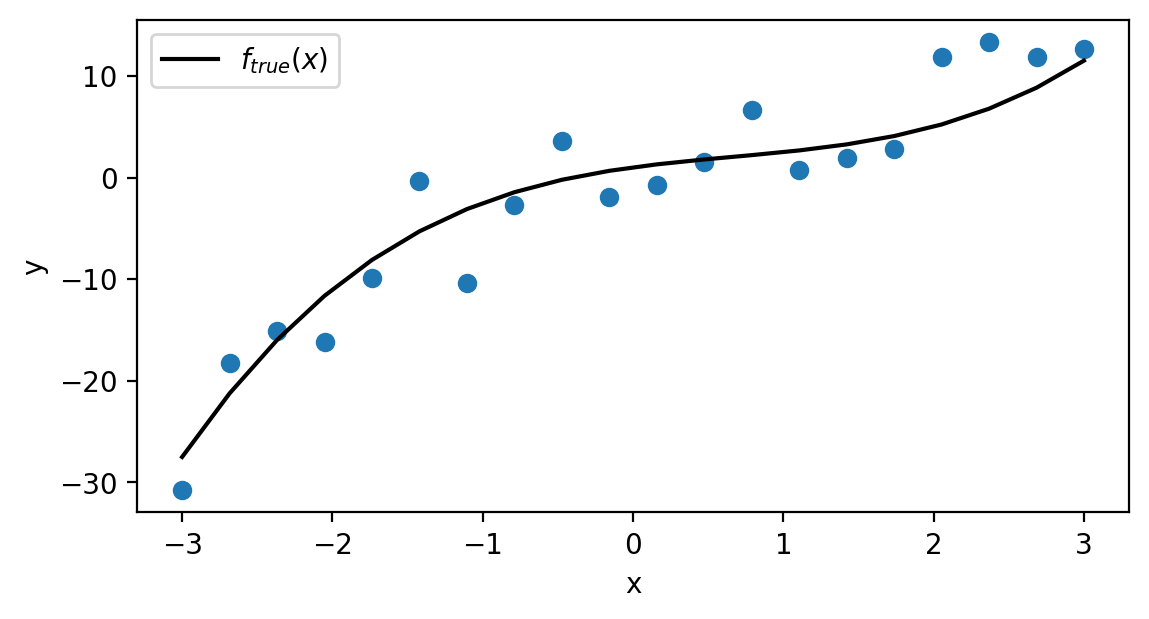

In [4]:
fig = plt.figure(figsize=(6.4, 3.2), dpi=200)
ax = plt.axes()

ax.scatter(x_data, y_data)
ax.plot(x_data, f_true(x_data), color="k", label=r"$f_{true}(x)$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

plt.show()

In [5]:
# Model 1: 3-degree polynomial
from scipy.stats import norm

def log_prior_3(coeffs):
    return np.sum(norm.logpdf(coeffs, 0, 10))

def log_likelihood_3(coeffs, x, y):
    model = f_model(x, coeffs)
    return -0.5 * np.sum((y - model)**2 / 3**2)

def log_posterior_3(coeffs, x, y):
    return log_prior_3(coeffs) + log_likelihood_3(coeffs, x, y)

ndim_3 = 4
nwalkers_3 = 10
initial_3 = np.random.uniform(-1, 1, size=(nwalkers_3, ndim_3)) 
sampler_3 = emcee.EnsembleSampler(nwalkers_3, ndim_3, log_posterior_3, args=(x_data, y_data))
sampler_3.run_mcmc(initial_3, 5000, progress=True)
samples_3 = sampler_3.get_chain(discard=1000, flat=True)

map_estimate_3 = samples_3[np.argmax(sampler_3.get_log_prob(discard=1000, flat=True))]

100%|██████████| 5000/5000 [00:05<00:00, 961.14it/s] 


In [6]:
# Model 2: 7-degree polynomial
def log_prior_7(coeffs):
    return np.sum(norm.logpdf(coeffs, 0, 10))

def log_likelihood_7(coeffs, x, y):
    model = f_model(x, coeffs)
    return -0.5 * np.sum((y - model)**2 / 3**2)

def log_posterior_7(coeffs, x, y):
    return log_prior_7(coeffs) + log_likelihood_7(coeffs, x, y)

ndim_7 = 8
nwalkers_7 = 50
initial_7 = np.random.uniform(-1, 1, size=(nwalkers_7, ndim_7))
sampler_7 = emcee.EnsembleSampler(nwalkers_7, ndim_7, log_posterior_7, args=(x_data, y_data))
sampler_7.run_mcmc(initial_7, 5000, progress=True)
samples_7 = sampler_7.get_chain(discard=1000, flat=True)

map_estimate_7 = samples_7[np.argmax(sampler_7.get_log_prob(discard=1000, flat=True))]

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:24<00:00, 201.77it/s]


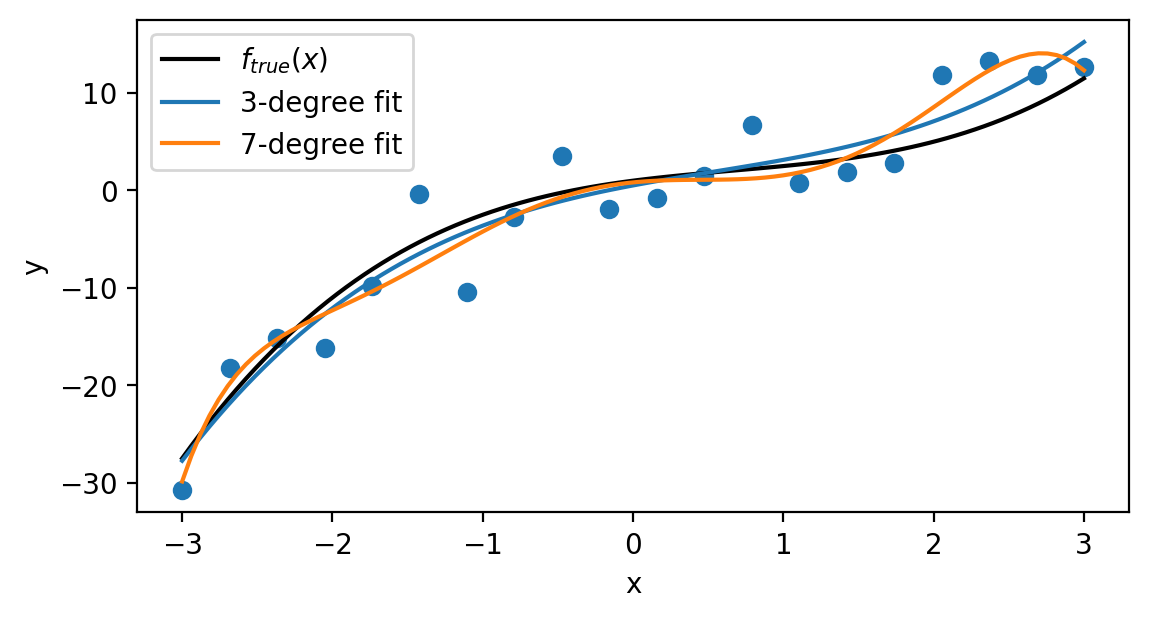

In [7]:
x_plot = np.linspace(-3, 3, 100)
y_plot_3 = f_model(x_plot, map_estimate_3)
y_plot_7 = f_model(x_plot, map_estimate_7)

fig = plt.figure(figsize=(6.4, 3.2), dpi=200)
ax = plt.axes()

ax.scatter(x_data, y_data)
ax.plot(x_plot, f_true(x_plot), color="k", label=r"$f_{true}(x)$")
ax.plot(x_plot, y_plot_3, label="3-degree fit")
ax.plot(x_plot, y_plot_7, label="7-degree fit")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

plt.savefig("./figures/lec9/polynomial-fit.png")
plt.show()

In [8]:
# Occam's Razor: Model comparison
from scipy.optimize import minimize
from numdifftools import Hessian

def laplace_approximation(log_posterior, x, y, theta_init):
    neg_log_post = lambda theta: -log_posterior(theta, x, y)
    result = minimize(neg_log_post, x0=theta_init, method='BFGS')
    theta_map = result.x
    
    hess = Hessian(neg_log_post)(theta_map)
    Sigma = np.linalg.inv(hess)
    
    return theta_map, Sigma

def marginal_likelihood_laplace(log_posterior, log_prior, x, y, theta_init):
    theta_map, Sigma = laplace_approximation(log_posterior, x, y, theta_init)
    d = len(theta_map)
    
    log_likelihood_map = log_posterior(theta_map, x, y) - log_prior(theta_map)
    log_prior_map = log_prior(theta_map)
    
    log_evidence = (log_likelihood_map + 
                   log_prior_map + 
                   0.5 * d * np.log(2 * np.pi) + 
                   0.5 * np.linalg.slogdet(Sigma)[1])
    
    return log_evidence

log_evidence_3 = marginal_likelihood_laplace(log_posterior_3, log_prior_3, x_data, y_data, np.zeros(ndim_3))
log_evidence_7 = marginal_likelihood_laplace(log_posterior_7, log_prior_7, x_data, y_data, np.zeros(ndim_7))

print(f"Log Marginal Likelihood (3-degree): {log_evidence_3}")
print(f"Log Marginal Likelihood (7-degree): {log_evidence_7}")

# Bayes factor
bayes_factor = np.exp(log_evidence_3 - log_evidence_7)
print(f"Bayes Factor (3-degree vs 7-degree): {bayes_factor}")

Log Marginal Likelihood (3-degree): -26.435576602028462
Log Marginal Likelihood (7-degree): -45.51470347304618
Bayes Factor (3-degree vs 7-degree): 193178824.7548526
